# WHL Rankings: The Shutdown & Gatekeeper Model

**Philosophy:** "Defense Wins Championships"

### 1. The Shutdown Metric (Defense - 50%)
- **Shutdown Quality:** `xGA per Game` (Lower is better). Measures system ability to suppress chances.
- **Defensive Depth (Consistency):** `xGA Variance`. Low variance = Reliable structure (Tournament Tough).
- **PK Specialist:** `GA / xGA` Ratio. Ability to keep pucks out when expected goals are against them.

### 2. The Gatekeeper Factor (Goaltending - 50%)
- **GSAx:** `Total xGA - Total GA`. (Goals Saved Above Expected).
- **Stolen Wins (Sustainability):** Difference between `Actual Points %` and `xG Share %`. High positive = Goalie stealing games.
- **Sieve Alert:** Teams with *Elite Defense* (Low xGA) but *Poor Goaltending* (High GA). True Sleepers if goaltending regresses to mean.


 Rank         team  PowerScore                            Status  xGA_per_GP   GSAx  Sustain_Diff
    1  netherlands       88.94                     ELITE DEFENSE        0.13  27.80         -0.35
    2  philippines       87.14                      ELITE GOALIE        0.15  50.13         -0.25
    3         peru       86.87                      ELITE GOALIE        0.13  36.93         -0.31
    4        india       82.94                      ELITE GOALIE        0.15  44.93         -0.33
    5        china       81.11                     ELITE DEFENSE        0.14  27.98         -0.34
    6       brazil       80.03                     ELITE DEFENSE        0.14  32.83         -0.37
    7 saudi_arabia       77.86                     ELITE DEFENSE        0.14  25.97         -0.31
    8           uk       76.86                                 -        0.15  29.00         -0.32
    9    indonesia       76.85                                 -        0.15  28.34         -0.30
   10      iceland  

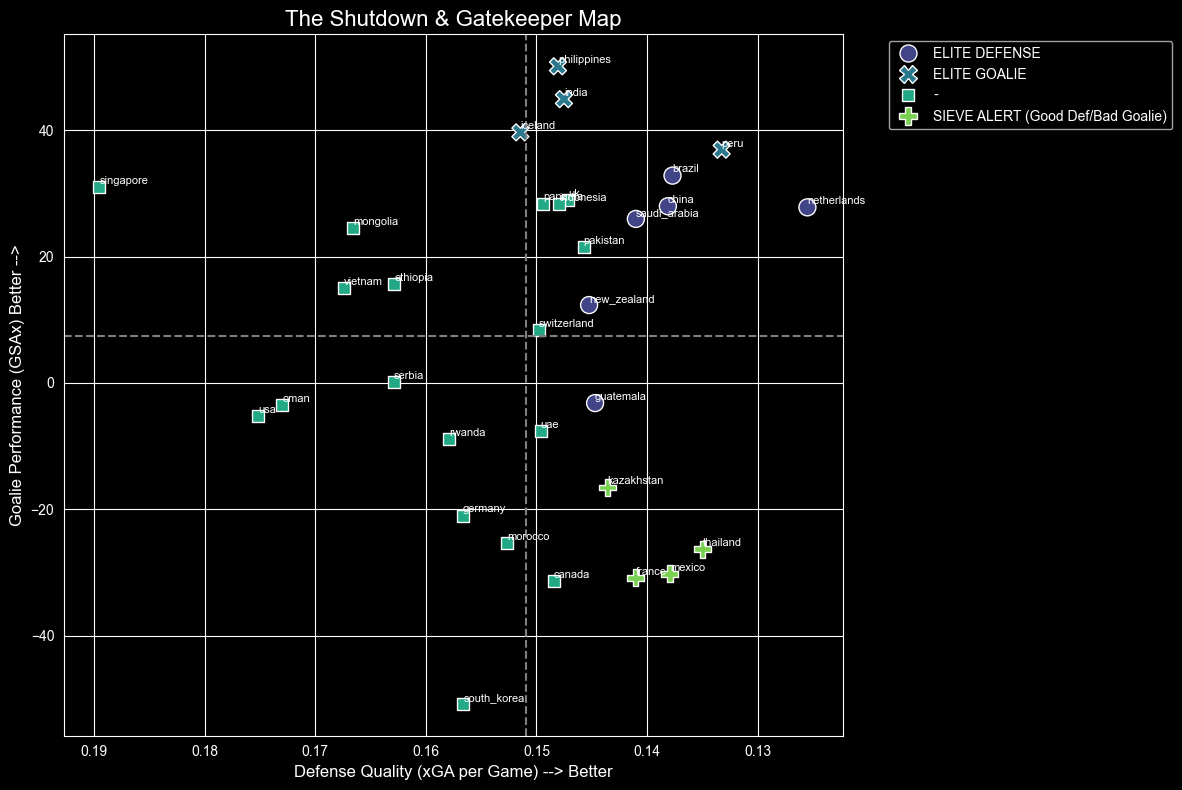

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, rankdata

# Load data
df = pd.read_excel('./datasci/cleanedup/whl_2025_base.xlsx')

# --- Data Processing (Team-Game Level) ---
home_df = df[['game_id', 'home_team', 'home_goals', 'away_goals', 'home_xg', 'away_xg', 'home_shots', 'away_shots', 'home_penalty_minutes', 'went_ot']].copy()
home_df.columns = ['game_id', 'team', 'gf', 'ga', 'xgf', 'xga', 'sf', 'sa', 'pim', 'is_ot']
home_df['is_home'] = 1
# Simple Points Calculation (2 for win, 1 for OT loss? We'll assume Win=2)
home_df['pts'] = np.where(home_df['gf'] > home_df['ga'], 2, np.where(home_df['is_ot'] == 1, 1, 0))

away_df = df[['game_id', 'away_team', 'away_goals', 'home_goals', 'away_xg', 'home_xg', 'away_shots', 'home_shots', 'away_penalty_minutes', 'went_ot']].copy()
away_df.columns = ['game_id', 'team', 'gf', 'ga', 'xgf', 'xga', 'sf', 'sa', 'pim', 'is_ot']
away_df['is_home'] = 0
away_df['pts'] = np.where(away_df['gf'] > away_df['ga'], 2, np.where(away_df['is_ot'] == 1, 1, 0))

team_games = pd.concat([home_df, away_df], ignore_index=True)

# --- Aggregations & Metrics ---
stats = team_games.groupby('team').agg(
    gp=('game_id', 'count'),
    gf=('gf', 'sum'),
    ga=('ga', 'sum'),
    xgf=('xgf', 'sum'),
    xga=('xga', 'sum'),
    pts=('pts', 'sum'),
    xga_var=('xga', 'var') # Variance of Expected Goals Against (Consistency Proxy)
).reset_index()

# 1. The Shutdown Metric (Defense)
stats['xGA_per_GP'] = stats['xga'] / stats['gp']
stats['Def_Consistency'] = stats['xga_var'] # Lower is better

# 2. The Gatekeeper Factor (Goaltending)
stats['GSAx'] = stats['xga'] - stats['ga']
stats['PTS_Pct'] = stats['pts'] / (stats['gp'] * 2)
stats['xG_Share'] = stats['xgf'] / (stats['xgf'] + stats['xga'])
stats['Sustain_Diff'] = stats['PTS_Pct'] - stats['xG_Share']
# Sustain_Diff > 0: Overperforming (Goalie Saved Them?)
# Sustain_Diff < 0: Underperforming (Goalied?)

# --- Normalization & Ranking ---
def normalize(series, invert=False):
    if invert:
        return 1 - ((series - series.min()) / (series.max() - series.min()))
    return (series - series.min()) / (series.max() - series.min())

# Defense Score (Higher is better)
# Low xGA is good (Invert)
# Low Variance is good (Invert)
stats['Score_Def'] = (normalize(stats['xGA_per_GP'], invert=True) * 0.7) + (normalize(stats['Def_Consistency'], invert=True) * 0.3)

# Goalie Score (Higher is better)
# High GSAx is good
# High Sustain Diff? Actually we want sustainable power.
# The user said: "High GSAx = Elite". "If win despite being outshot... Rank is FRAGILE".
# So we reward GSAx, but maybe penalize extreme reliance on it?
# Request: "Weight Team xG higher than Actual Wins".
# Let's stick to GSAx as the core "Gatekeeper" quality metric.
stats['Score_Goalie'] = normalize(stats['GSAx'])

# Final Ranking (50/50 Split)
stats['PowerScore'] = (stats['Score_Def'] * 0.5 + stats['Score_Goalie'] * 0.5) * 100
stats['Rank'] = stats['PowerScore'].rank(ascending=False).astype(int)
stats = stats.sort_values('Rank')

# --- The "Sieve" Alert Logic ---
# Top 33% Defense (Low xGA) AND Bottom 33% Goaltending (Low GSAx)
xga_threshold = stats['xGA_per_GP'].quantile(0.33)
gsax_threshold = stats['GSAx'].quantile(0.33)

def sieves(row):
    if row['xGA_per_GP'] <= xga_threshold and row['GSAx'] <= gsax_threshold:
        return 'SIEVE ALERT (Good Def/Bad Goalie)'
    if row['GSAx'] >= stats['GSAx'].quantile(0.90):
        return 'ELITE GOALIE'
    if row['xGA_per_GP'] <= xga_threshold:
        return 'ELITE DEFENSE'
    return '-'

stats['Status'] = stats.apply(sieves, axis=1)

# --- Output ---
cols = ['Rank', 'team', 'PowerScore', 'Status', 'xGA_per_GP', 'GSAx', 'Sustain_Diff']
print(stats[cols].to_string(index=False, float_format='%.2f'))

# --- Visuals ---
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))

# Quadrant Plot: Defense Quality (xGA/GP) vs Goalie Performance (GSAx)
# Note: xGA/GP is better when LOWER. So we invert X axis or interpret left as good.
sns.scatterplot(
    data=stats,
    x='xGA_per_GP',
    y='GSAx',
    hue='Status',
    style='Status',
    s=150,
    palette='viridis'
)

# Invert X axis so Right = Better Defense? Or Left = Better?
# Standard is Left = Lower xGA = Better.
plt.gca().invert_xaxis()

for i, row in stats.iterrows():
    plt.text(row['xGA_per_GP'], row['GSAx']+0.5, row['team'], fontsize=8, color='white')

plt.title('The Shutdown & Gatekeeper Map', fontsize=16)
plt.xlabel('Defense Quality (xGA per Game) --> Better', fontsize=12)
plt.ylabel('Goalie Performance (GSAx) Better -->', fontsize=12)
plt.axvline(stats['xGA_per_GP'].mean(), color='gray', linestyle='--')
plt.axhline(stats['GSAx'].mean(), color='gray', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
# --- LOGIC FOR home_def_pairing (The Shutdown Metric) ---
# 1. Shutdown Quality: Calculate 'xG Allowed per 60' for each pairing.
#    A team's 'Defensive Rank' should be heavily weighted by the first_def unit.
#
# 2. Defensive Depth: Measure the 'Reliability Gap' between 1st and 2nd pairs.
#    Teams with a strong second_def are 'Tournament Hardened' and harder to exploit.
#
# 3. PK Specialist Rank: Filter for 'PP_kill_dwn'.
#    Identify teams that effectively suppress xG even when man-down.
#    High PK efficiency is a major signal for 'Playoff Ready' power rankings.
#
# 4. Goal-Save Delta: Compare 'Actual Goals Allowed' vs 'xG Allowed' per pairing.
#    If a pairing allows high xG but zero goals, the goalie is 'bailing them out'.
# --- LOGIC FOR GOALIE COLUMNS (The Gatekeeper Factor) ---
# 1. GSAx (Goals Saved Above Expected): Compare 'Actual Goals Allowed' vs 'Total xG'.
#    - Formula: GSAx = Total xG - Actual Goals.
#    - ACTION: High GSAx = Elite Goalie. Low GSAx = Weak Link.
#
# 2. Standings vs. Process: Identify teams 'carried' by their goalie.
#    - If a team wins despite being out-shot (low xG share), their rank is FRAGILE.
#    - ACTION: Weight 'Team xG' higher than 'Actual Wins' to find sustainable power.
#
# 3. Goalie Split: Check if a team has a clear 'Starter' vs 'Backup'.
#    - Does the team's Win % drop significantly when the backup goalie is in?
#    - ACTION: Create a 'Roster Reliability' score based on the gap between goalies.

# 4. The 'Sieve' Alert: Flag teams with high xG suppression (great defense)
#    but high Goals Against (bad goalie). These are 'Sleepers' if they swap goalies.,
#      not just a favorable home schedule.